In [1]:
import re
import os
import pathlib
import json
from typing import List, TypedDict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore")
sns.set_theme(style="darkgrid")

%matplotlib inline

In [2]:
experiment = "01_http_max_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()

In [3]:
# Represents a single data point of system utilization
class ResourceResult(TypedDict):
    mesh: str
    qps: str
    pod: str
    container: str
    time: int
    cpu: float
    mem: float


def parse_resource_results(result_file: pathlib.Path) -> List[ResourceResult]:
    """ Reads a result file and parses the data.

    The returned data is a list of ResourceResults that represent a
    single metric over a time span of 15 minutes.
    """
    rows = []

    # Regex to extra# 0 -> Full match
    # 1 -> mem/cpu results
    # 2 -> Mesh
    # 3 -> Requested QPS
    name_re = re.compile("^(mem|cpu)_([a-z]+)_(\d+|MAX).*json$")

    # Extract metadata from the result
    matches = name_re.match(file)

    metric = matches[1]
    mesh = matches[2]
    qps = matches[3]
    # print(f"Type: {metric}, Mesh: {mesh}, QPS: {qps}")

    with open(result_file) as f:
        data = json.load(f)

    # The resutl is lister per pod/container
    for container in data:

        # Metadata (dimensions)
        meta = container["metric"]

        # Actual values in list[unixtime, value]
        values = container["values"]

        for v in values:
            row: ResourceResult = {
                "mesh": mesh,
                "qps": qps,
                "pod": meta["pod"],
                "container": meta["container"],
                "time": v[0],
                metric: v[1],
            }
            rows.append(row)

    return rows


In [4]:

"""
Generate a list of rows containing a single metric (either cpu or mem)
These later have to be merged based on time
"""


results = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Skip non system resource files
        if not re.match("^(mem|cpu).*$", file):
            continue

        
        path = (pathlib.Path(root) / file).resolve()
        res = parse_resource_results(path)
        results.extend(res)

Parsing Experiment results:
Exp: 01_http_max_throughput
Results: 15


In [5]:
""" Create a pandas DataFrame
- Each row represents a single observation
- Each observation takes a form of type ResourceResult
- Rows are merged based on time/pod/container -> this halves rows as both CPU/mem metrics share unix timestamps
- Convert unix timestamps to pd.DateTime
"""


# Initial dataset
df = pd.DataFrame(data=results)

# Merged CPU/mem results
df = df.groupby(by=["mesh", "qps", "pod", "container", "time"], as_index=False).first()

# Convert time column to datetime
df["date"] = pd.to_datetime(df["time"],unit="s")
df["cpu"] = pd.to_numeric(df["cpu"])
df["mem"] = pd.to_numeric(df["mem"])
df["mem_kb"] = df["mem"] / 1000
df["mem_mb"] = df["mem_kb"] / 1000

# Remove some unrelated rows
df = df.drop(df.index[df["container"] == "node-init"])
df = df.drop(df.index[df["container"] == "cilium-operator"])

df.describe()

,time,cpu,mem,mem_kb,mem_mb
count,2.699000e+03,2699.000000,2.699000e+03,2699.000000,2699.000000
mean,1.656294e+09,0.543200,1.904411e+05,190.441146,0.190441
std,2.930513e+04,0.415506,2.710455e+05,271.045550,0.271046
min,1.656254e+09,0.000103,0.000000e+00,0.000000,0.000000
25%,1.656268e+09,0.157908,2.035317e+04,20.353174,0.020353
50%,1.656277e+09,0.573359,1.029779e+05,102.977885,0.102978
75%,1.656322e+09,1.021143,1.960749e+05,196.074945,0.196075
max,1.656331e+09,1.194379,2.270945e+06,2270.945435,2.270945


In [6]:
def plot_cpu_usage(ax: matplotlib.axes, data: pd.DataFrame) -> matplotlib.axes:
    """Plots the resource utilization on a given axes.

    y: CPU usage in fractios of a CPU core per second
    x: date
    """

    # Calculate time deltas
    time_delta = data.date - data.date.min()

    sns.lineplot(data=data, x=time_delta, y="cpu", hue="container", ax=ax)

    mesh = data["mesh"].iloc[0].capitalize()
    qps = data["qps"].iloc[0].capitalize()

    # Labels
    plot_title = f"$\\bf{mesh}$\n" f"RPS: {qps}\n"
    ax.set_ylabel("CPU usage")
    ax.set_xlabel("Time in minutes")
    ax.set_title(plot_title, y=1.07)

    # X axis configuration
    # Major tick -> Every 5 minutes
    # Minor tick -> Every minute
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=3))
    ax.set_xticklabels([0, 5, 15])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.minorticks_on()
    ax.tick_params(axis="x", direction="in", which="both", bottom=True)

    # Y axis configuration
    ax.set_ylim(bottom=0, top=1.25)

    # Place legend above axes
    # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.legend(
        bbox_to_anchor=(0, 0.92, 1, 0.2), mode="expand", ncol=2, loc="upper center"
    )

    return ax


In [7]:
def plot_memory_usage(ax: matplotlib.axes, data: pd.DataFrame) -> matplotlib.axes:
    """Plots the resource utilization on a given axes.

    y: Memory usage in bytes
    x: date
    """

    # Calculate time deltas
    time_delta = data.date - data.date.min()

    sns.lineplot(
        data=data,
        x=time_delta,
        y="mem_kb",
        hue="container",
        ax=ax,
    )

    mesh = data["mesh"].iloc[0].capitalize()
    qps = data["qps"].iloc[0].capitalize()

    # Labels
    plot_title = f"$\\bf{mesh}$\n" f"RPS: {qps}\n"
    ax.set_ylabel("Memory usage (KB)")
    ax.set_xlabel("Time (minutes)")
    ax.set_title(plot_title, y=1.07)

    # X axis configuration
    # Major tick -> Every 5 minutes
    # Minor tick -> Every minute
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=3))
    ax.set_xticklabels([0, 5, 15])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.minorticks_on()
    ax.tick_params(axis="x", direction="in", which="both", bottom=True)

    # Y axis configuration
    ax.set_ylim(bottom=0, top=2500)

    # Place legend above axes
    # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.legend(
        bbox_to_anchor=(0, 0.92, 1, 0.2), mode="expand", ncol=2, loc="upper center"
    )

    return ax


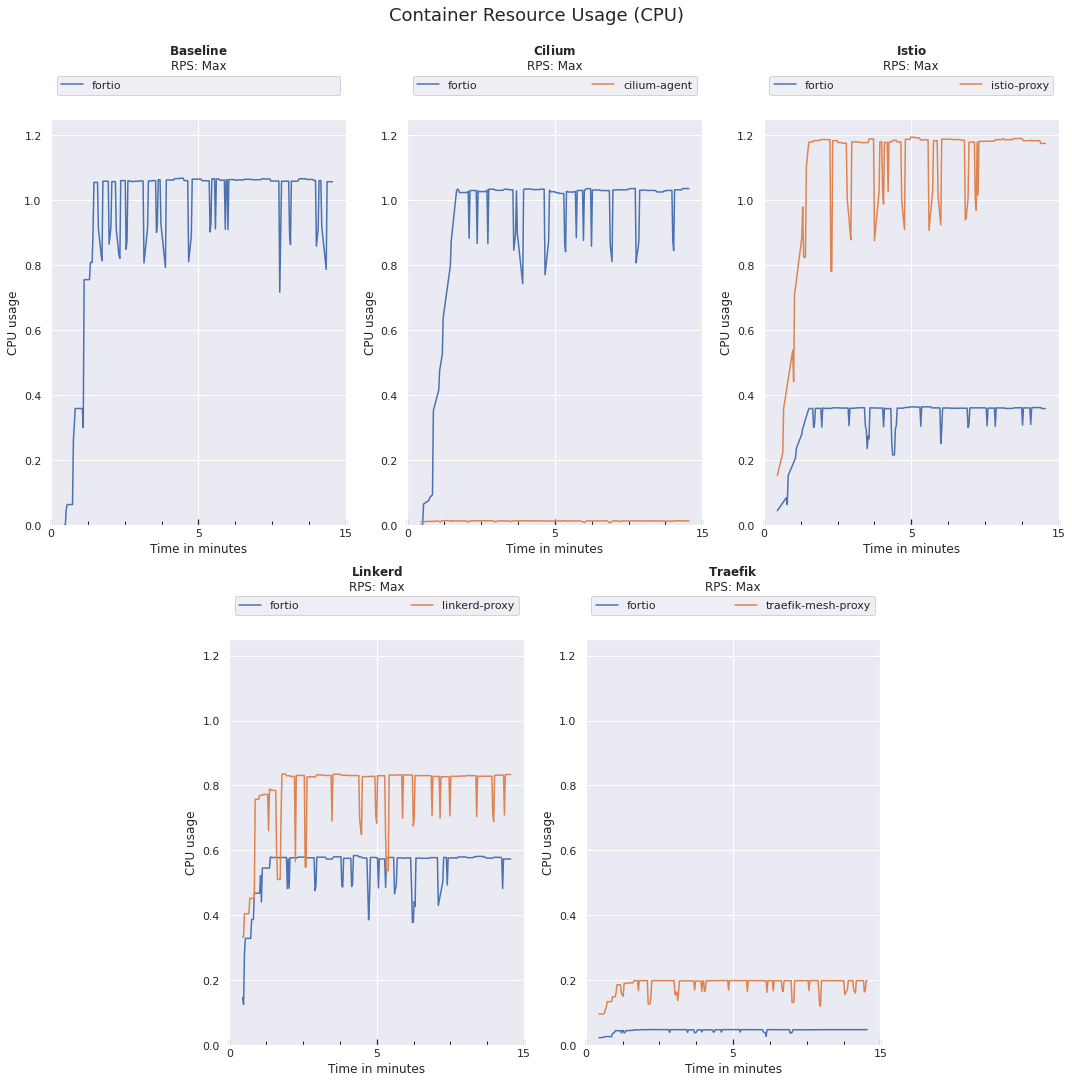

In [8]:
"""Plot CPU utilization results"""

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=2, ncols=6)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[0, 4:6]),
    # Row 1 (offset by 1)
    fig.add_subplot(gs[1, 1:3]),
    fig.add_subplot(gs[1, 3:5]),
]

# Set figure title
fig.suptitle("Container Resource Usage (CPU)", fontsize=18, y=1)

meshes = df["mesh"].unique()
meshes.sort()
meshes

for i, m in enumerate(meshes):
    # Subset dataframe
    data = df[df["mesh"] == m]

    # Fix color ordering
    if m == "cilium":
        data = data.sort_values("container", ascending=False)

    plot_cpu_usage(ax=axes[i], data=data)

fig.tight_layout()
fig.savefig(plot_dir / "exp_01-cpu-results.pdf")
plt.show()


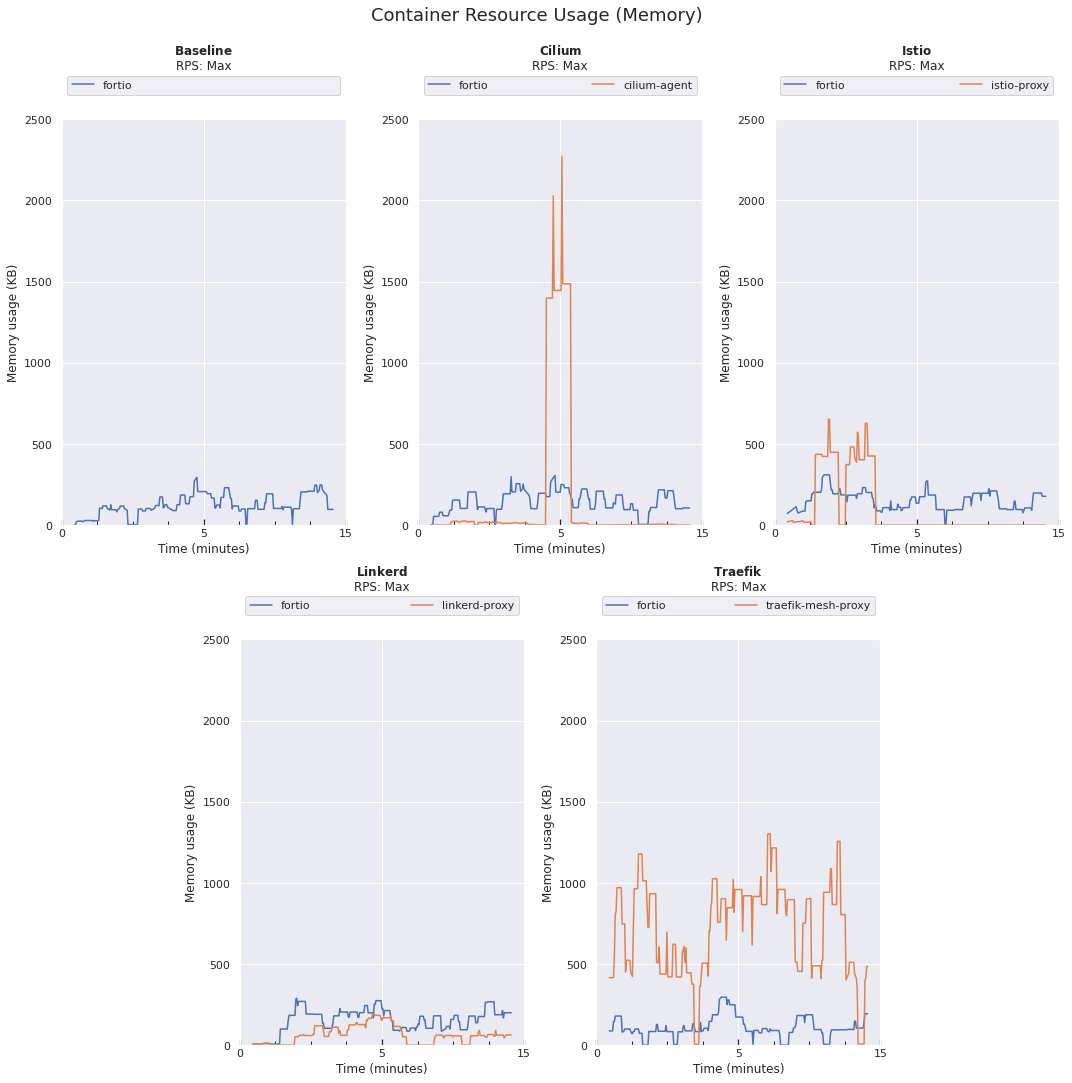

In [9]:
""" Plot memory utilization results
"""
# Create grid of
fig = plt.figure(figsize=(15, 15))

# Create a grid of subplots
gs = gridspec.GridSpec(nrows=2, ncols=6)

# Create subplots, each plot is 2 cols wide
axes = [
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[0, 4:6]),
    # Row 1 (offset by 1)
    fig.add_subplot(gs[1, 1:3]),
    fig.add_subplot(gs[1, 3:5]),
]

# Set figure title
fig.suptitle("Container Resource Usage (Memory)", fontsize=18, y=1)

meshes = df["mesh"].unique()
meshes.sort()
meshes

for i, m in enumerate(meshes):
    # Subset dataframe
    data = df[df["mesh"] == m]

    # Fix color ordering
    if m == "cilium":
        data = data.sort_values("container", ascending=False)

    plot_memory_usage(ax=axes[i], data=data)

fig.tight_layout()
fig.savefig(plot_dir / "exp_01-memory-results.pdf")
plt.show()
